# Using LIME for explaining Image Classifiers
## CHAPTER 05 - *Practical Exposure of using LIME in ML*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

In this notebook, we will applying LIME to explain black-box image classifiers. Before starting with this notebook, I would recommend you to go through the concepts discussed in *Chapter 05 - Practical Exposure of using LIME in ML* and *Chapter 04 - Introduction to LIME for model interpretability* to have a better understanding on the code provided in the notebook.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn tensorflow lime scikit-image

### Loading the modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

In [2]:
print(f" Version of tensorflow used: {tf.__version__}")

 Version of tensorflow used: 2.3.1


### Loading the data

Since we are more interested to check how black-box image classifiers can be explained using LIME, we will focus only on the inference part. Let us load any generic image data. For this example, we will take the data from this source: https://i.imgur.com/1Phh6hv.jpeg

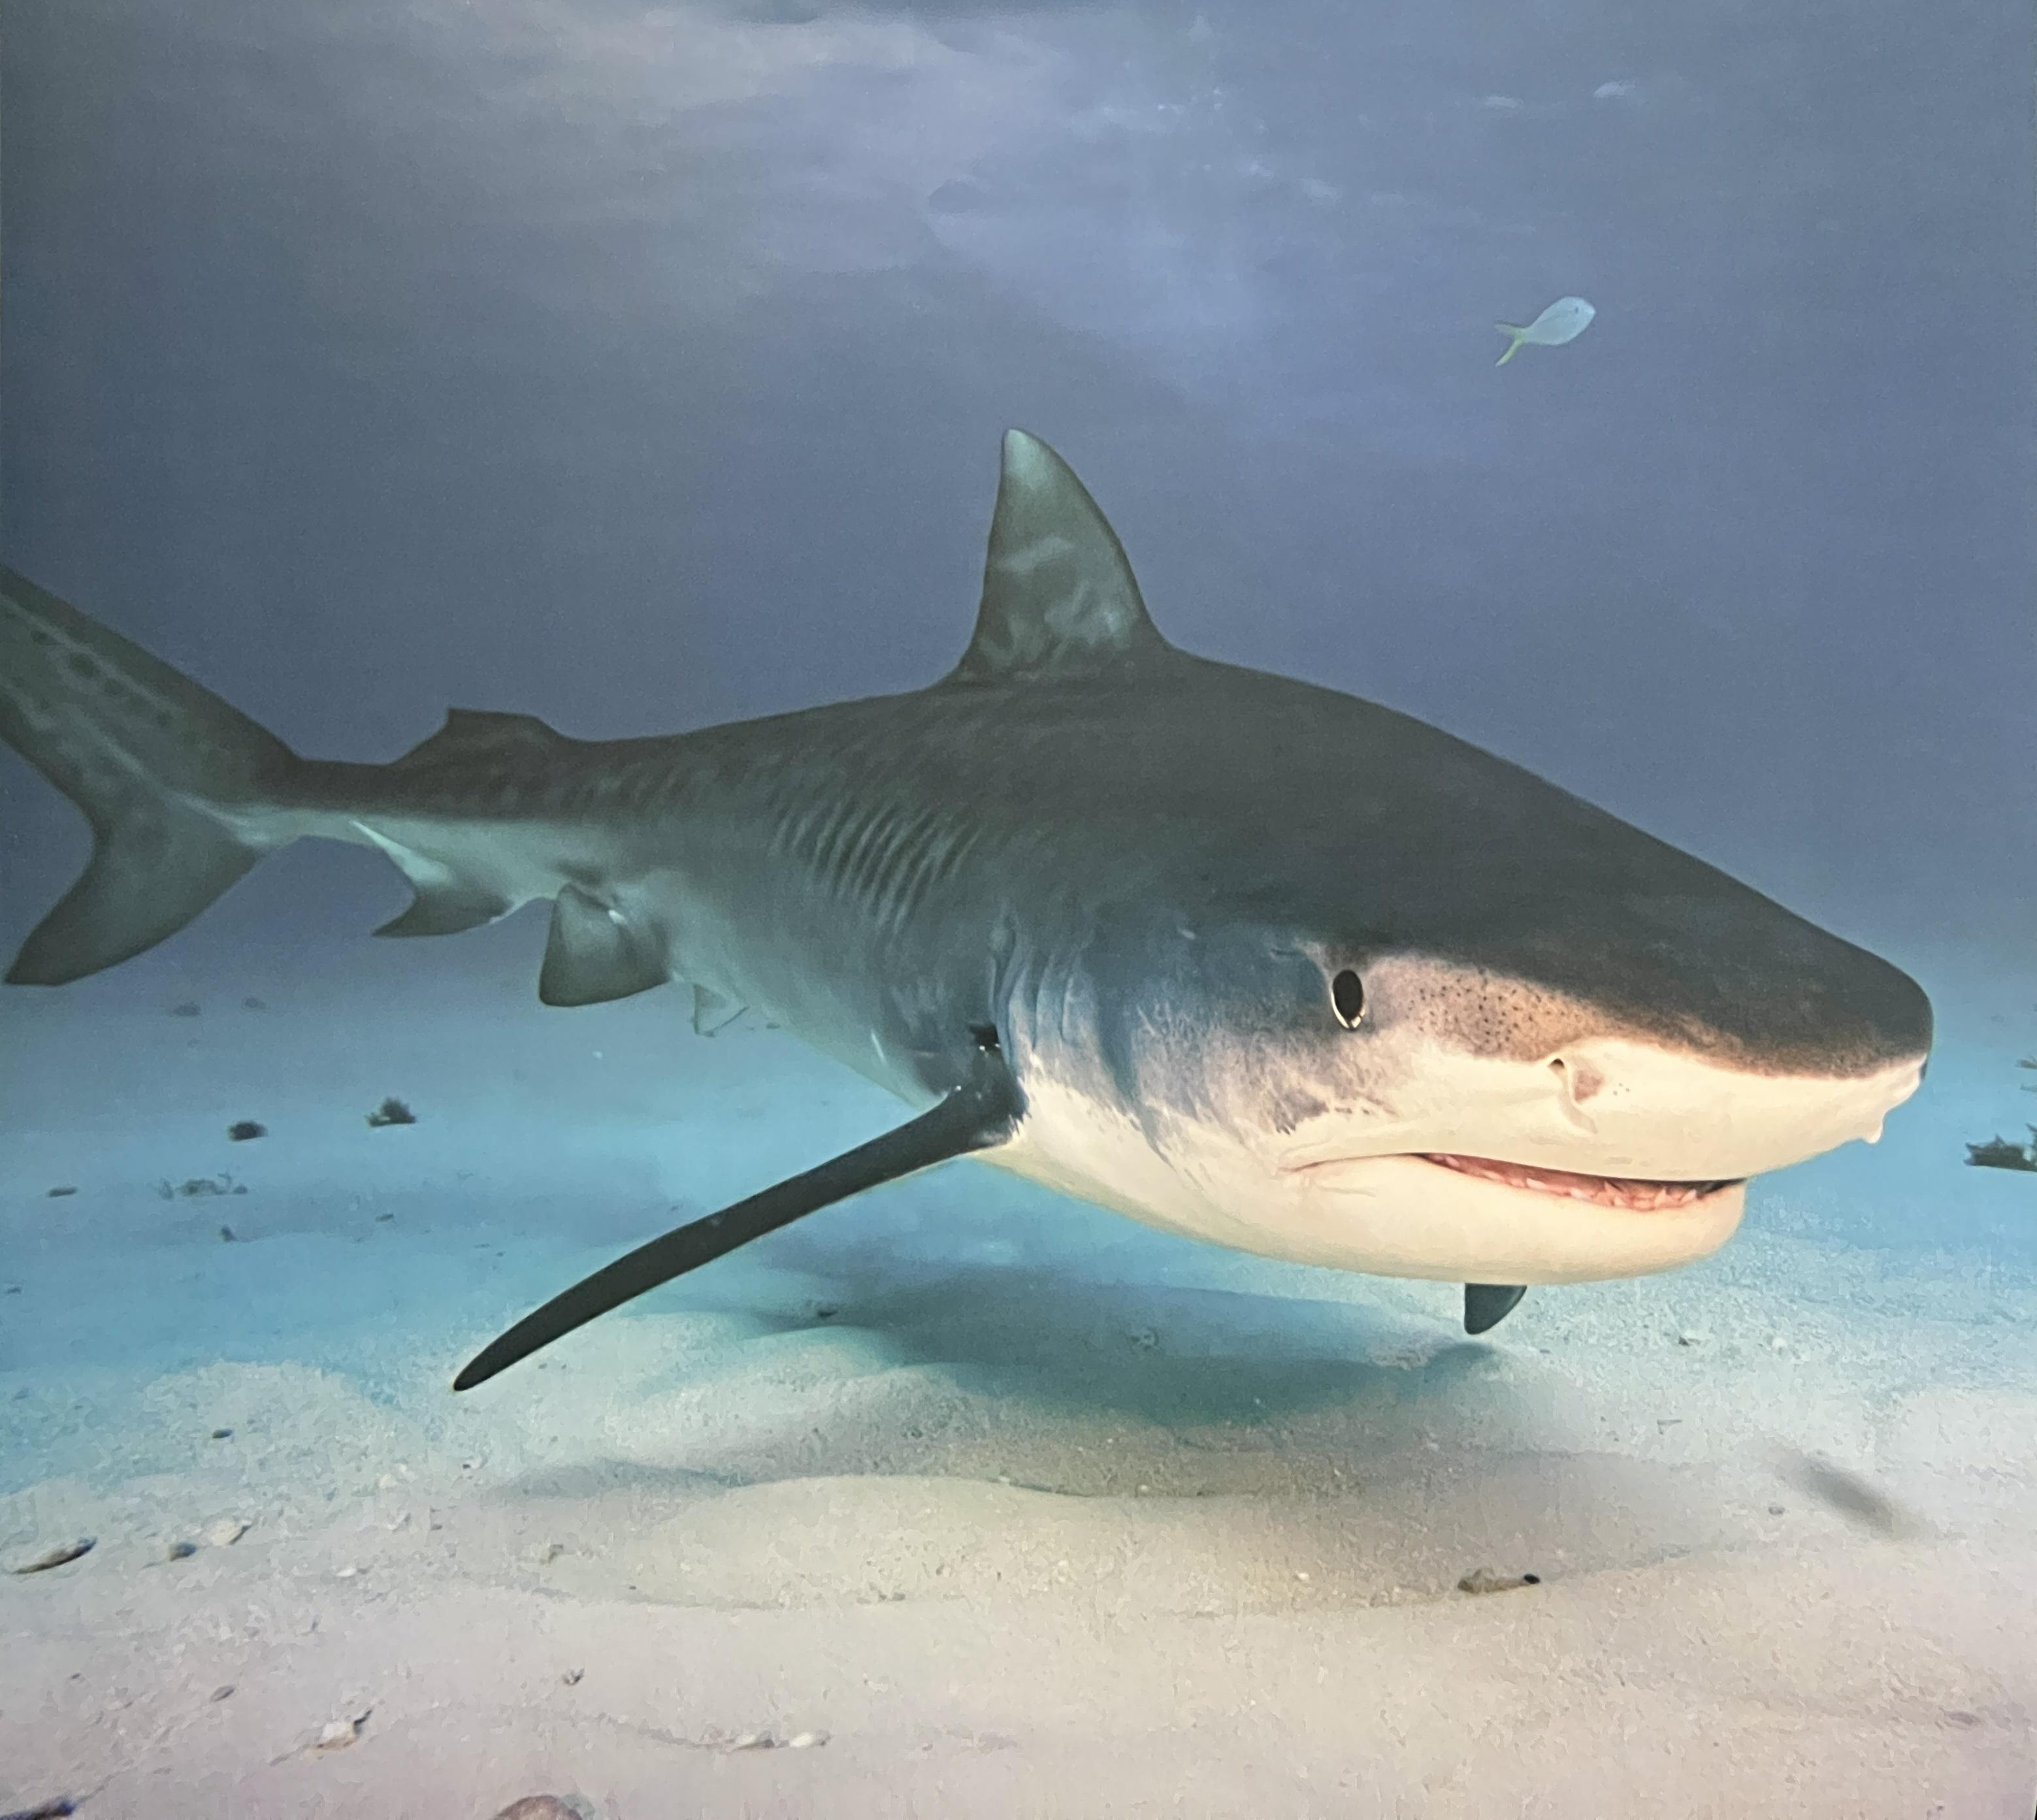

In [3]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "shark.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = "https://i.imgur.com/1Phh6hv.jpeg")

Similar to other tutorials covered in this chapter where image classifiers are used. We will perform some initial data pre-processing with images.

In [4]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

### Defining the model

For this example, we are not training a model from scratch, but rather defining a pretrained Tensorflow Xception model as our black-box Deep Learning model which we will be explaining using the LIME framework.

The predicted class is : tiger_shark


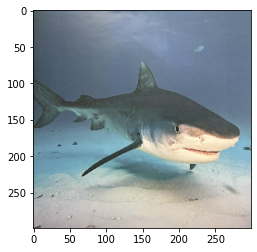

In [5]:
model = Xception(weights="imagenet")

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)

The image is predicted as *Tiger Shark* which is the correct prediction and the black-box model is successfully able to give the correct prediction. Now, let us even take a look at the top 5 predictions along with the model confidences.

In [6]:
model_prediction = model.predict(normalized_img)
top5_pred = decode_predictions(model_prediction, top=5)[0]
for pred in top5_pred:
    print(pred[1])

tiger_shark
great_white_shark
hammerhead
scuba_diver
sturgeon


As we see, although the model is well trained to produce the correct prediction, but there are chances that the model is not just looking into main object in the image but as well as the surrounding background. This is evident from the prediction of *scuba_driver* present in the top 5 prediction list. So, it is important for us understand, the key components or parts of the image the model is looking into to make the prediction.

### Model Explanation with LIME

Now, we will use the LIME framework to identify "super-pixels" or image segments used by the model to predict the outcome.

In [7]:
explainer = lime_image.LimeImageExplainer()

In [8]:
exp = explainer.explain_instance(normalized_img[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Our explainer object is ready, but let us visualize the various explanation segments created by the LIME algorithm.

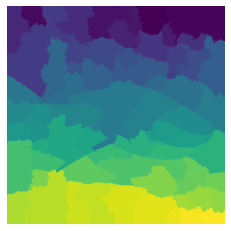

In [10]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

Now, let us use the top segments or super pixels to identify the region of interest of the image used by the model to make its prediction.

In [11]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

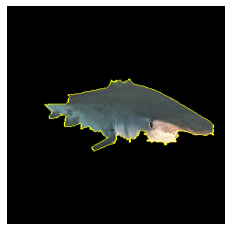

In [12]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

As we can see from the above image that the model was able to identify the correct region, which does indicate the correct prediction of the outcome by the model.

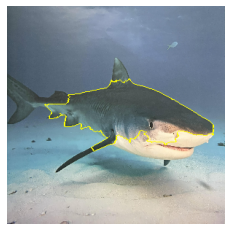

In [13]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

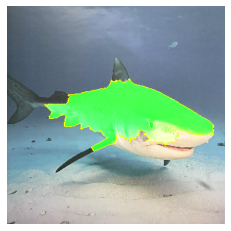

In [14]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

The above samples show us how we can hide or show the background along with the super-pixels or even outline or highlight the super-pixels to identify the region of interest used by the model to make the prediction. What we see from here does make sense, and does allow us to increase trust towards black-box models. We can also form a heat-map to show how important each super-pixel is to get some more granular explaianbility.

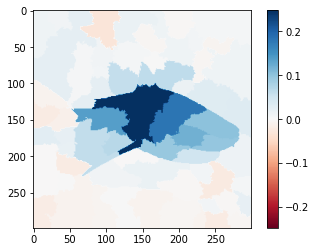

In [15]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

We can clearly identify the most influential segments used by the model to make the prediction using this heatmap visualization.

Now, let try to perform the same steps for another explanation class and see if the results are different.

In [16]:
index = 2
print(f"We will deal with predicted class: {top5_pred[index][1]}")

We will deal with predicted class: hammerhead


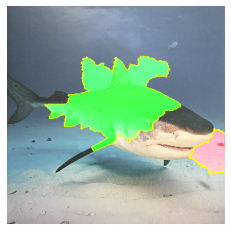

In [17]:
generate_prediction_sample(exp, exp.top_labels[index], weight = 0.0001, show_positive = False, hide_background = False)

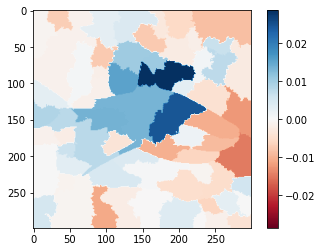

In [18]:
explanation_heatmap(exp, exp.top_labels[index])

In this case, we are trying to find out what made the model predict the outcome as *hammerhead shark*. When we used the LIME explaianbility methods, the visualizations clearly show that the middle part of the shark along with its fin, does contribute positively towards predicting the outcome as *hammerhead shark*, but the face and the front part contribute negatively towards the prediction. This is quite consistent with our human knowledge as well. *Hammerhead Sharks* are also sharks, so the middle part and the fin looks similar to *Tiger Sharks* but the face or the front portion of the hammerhead sharks looks like the shape of a hammer, which is significantly different from that of a tiger shark.

### Final Thoughts

As we clearly saw in this notebook, how LIME can be easily used to explain image classifiers. Next time, whenever you work on training Deep Learning models to classify images, I would strongly recommend you to try out LIME to explain your model and find out if the model is looking into right areas of the image to make the final prediction!

## Reference

1. The image is taken from Imgur: https://i.imgur.com/1Phh6hv.jpeg
2. LIME Open Source Python Framework in GitHub - https://github.com/marcotcr/lime
3. Research paper on LIME - [“Why Should I Trust You?”
Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf)
4. Original blog post on LIME by the author - https://homes.cs.washington.edu/~marcotcr/blog/lime/
4. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073